Source data: https://drive.google.com/file/d/1ufiR6hUKhXoAyiBNsySPkUwlvE_wfEHC/view

In [1]:
# !pip install opencv-python

In [2]:
import os
import random
from collections import defaultdict
from tqdm.autonotebook import tqdm

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import cv2
from PIL import Image

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torch.nn.functional as F

from sklearn.metrics import balanced_accuracy_score

import warnings
# filter warnings
warnings.filterwarnings('ignore')

/tmp/ipykernel_18831/3081382395.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


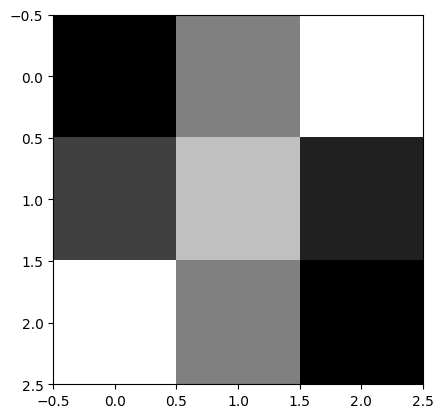

In [3]:
data = [[0, 128, 255], [64, 192, 32], [255, 128, 0]]
plt.imshow(data, cmap='gray')
plt.show()

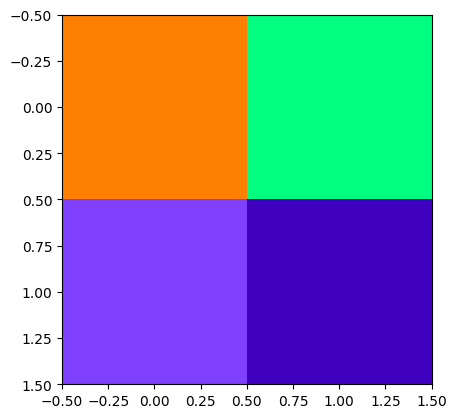

In [4]:
data = [[[255, 0], [128, 64]], [[128, 255], [64, 0]], [[0, 128], [255, 192]]]
data = np.moveaxis(data, 0, -1)
plt.imshow(data)
plt.show()

In [5]:
data_path = '../data/Module_3_Lecture_1_SIGNS_dataset/'
splits = ['train', 'test']

1080 images in train
Number of examples for class 0: 180


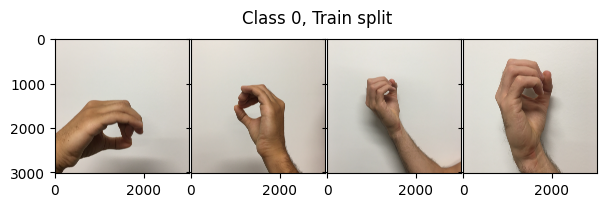

Number of examples for class 1: 180


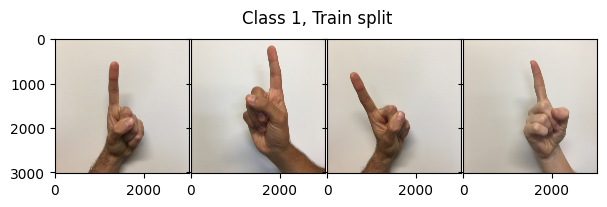

Number of examples for class 2: 180


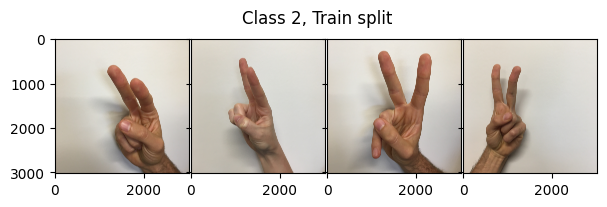

Number of examples for class 3: 180


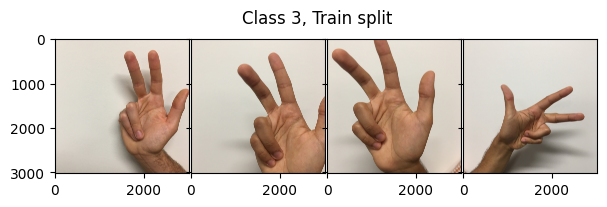

Number of examples for class 4: 180


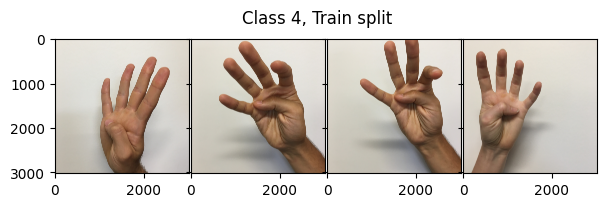

Number of examples for class 5: 180


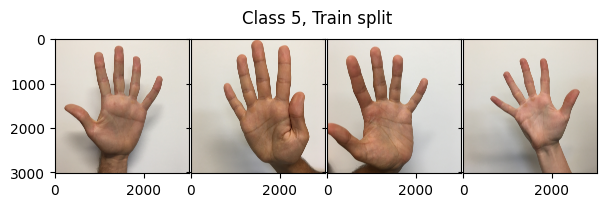

120 images in test
Number of examples for class 0: 20
Number of examples for class 1: 20
Number of examples for class 2: 20
Number of examples for class 3: 20
Number of examples for class 4: 20
Number of examples for class 5: 20


In [6]:
# Display images examples

for s in splits:
    files = [f for f in os.listdir(f"{data_path}{s}_signs") if f.endswith('.jpg')]
    print(f'{len(files)} images in {s}')
    
    files = [f.split('_', 1) for f in files]
    
    # group images by sign
    files_by_sign = defaultdict(list)
    for k, v in files:
        files_by_sign[k].append(v)
    
    # get random 4 images of each sign  
    for k, v in sorted(files_by_sign.items()):
        print(f'Number of examples for class {k}:', len(v))
            
        if s == 'train':              
            random.seed(42)
        
            imgs_path = random.sample(v, 4)
            imgs_path = [os.path.join(data_path, f'{s}_signs/{k}_{p}') for p in imgs_path]
        
            # read images with opencv
            imgs = [cv2.imread(p) for p in imgs_path]
            # Matplotlib expects img in RGB format but OpenCV provides it in BGR
            imgs = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in imgs]
            
            fig = plt.figure(figsize=(7, 2))
            grid = ImageGrid(
                fig, 111, 
                nrows_ncols=(1, 4)
            )
            for ax, img in zip(grid, imgs):
                ax.imshow(img)

            fig.suptitle(f'Class {k}, {s.capitalize()} split')
            plt.show()

In [7]:
# Image shape, (h, w, dim)
img.shape

(3024, 3024, 3)

Convolution layer

In [8]:
input = torch.randn(20, 16, 50, 100) # batch_size, in_channels, h, w

In [9]:
# With square kernels and equal stride
m = nn.Conv2d(16, 33, 3, stride=2)
output = m(input)
output.shape

torch.Size([20, 33, 24, 49])

In [10]:
# non-square kernels and unequal stride and with padding
m = nn.Conv2d(16, 33, (3, 5), stride=(2, 1), padding=(4, 2))
output = m(input)
output.shape

torch.Size([20, 33, 28, 100])

Pooling layer

In [11]:
input = torch.randn(20, 16, 50, 100) # batch_size, in_channels, h, w

In [12]:
# pool of square window of kernel_size=3, stride=2
m = nn.MaxPool2d(3, stride=2)
output = m(input)
output.shape

torch.Size([20, 16, 24, 49])

In [13]:
# pool of non-square window
m = nn.MaxPool2d((3, 2), stride=(2, 1))
output = m(input)
output.shape

torch.Size([20, 16, 24, 99])

Classification layers

## Augmentations

**Data Augmentation** is a technique used to artificially increase dataset size. Take a sample from the dataset, modify it somehow, add it to the original dataset — and now your dataset is one sample larger.

In [14]:
from PIL import Image

import torchvision.transforms as T

In [15]:
orig_img = Image.fromarray(img)

In [16]:
def plot_examples(transformed_imgs:list, col_titles:list, cmap=None):
    
    n_cols = len(transformed_imgs) +1
    fig_size_x = 3 + len(transformed_imgs) * 1.5
    fig, axs = plt.subplots(1, n_cols, figsize=(fig_size_x,2))
    
    axs[0].imshow(orig_img)
    axs[0].set_title('original image')
    
    for i in range(len(transformed_imgs)):
        axs[i+1].imshow(transformed_imgs[i], cmap=cmap)
        axs[i+1].set_title(col_titles[i])
    
    plt.tight_layout()
    plt.show()

**Resize**

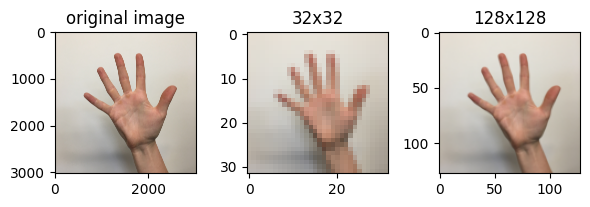

In [17]:
resized_imgs = [T.Resize(size=size)(orig_img) for size in [32,128]]

plot_examples(resized_imgs, ['32x32', '128x128'])

**Gray Scale**

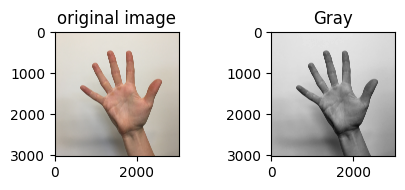

In [18]:
gray_img = T.Grayscale()(orig_img)

plot_examples([gray_img], ["Gray"], 'gray')

**Normalize**<br>
The normalization can constitute an effective way to speed up the computations in the model based on neural network architecture and learn faster. There are two steps to normalize the images:

* we subtract the channel mean from each input channel
* later, we divide it by the channel standard deviation.


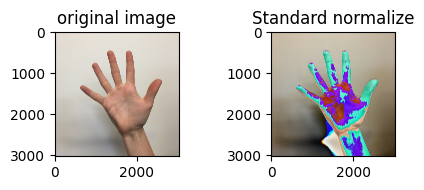

In [19]:
normalized_img = T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))(T.ToTensor()(orig_img)) 
normalized_img = [T.ToPILImage()(normalized_img)]

plot_examples(normalized_img, ["Standard normalize"])

**Random Rotation**

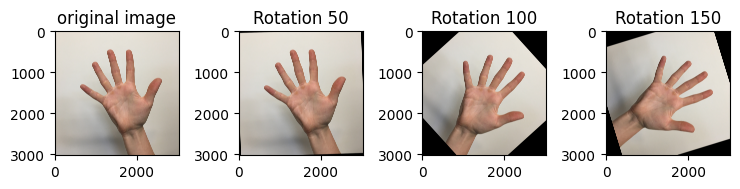

In [20]:
rotated_imgs = [T.RandomRotation(degrees=d)(orig_img) for d in range(50,151,50)]
plot_examples(rotated_imgs, ["Rotation 50","Rotation 100","Rotation 150"])

**Center Crop**

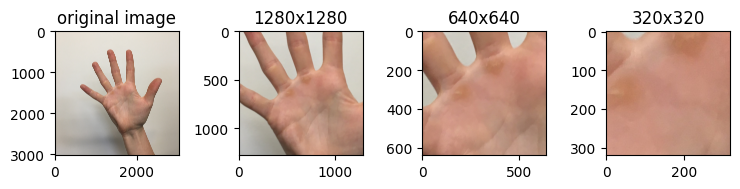

In [21]:
center_crops = [T.CenterCrop(size=size)(orig_img) for size in (1280,640, 320)]
plot_examples(center_crops,['1280x1280','640x640','320x320'])

**Random Crop**

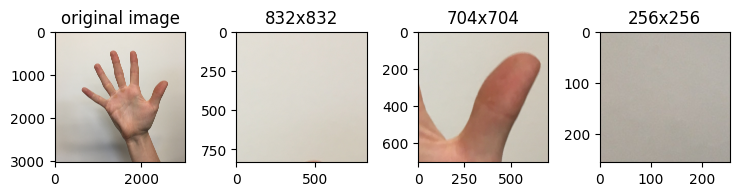

In [22]:
random_crops = [T.RandomCrop(size=size)(orig_img) for size in (832,704, 256)]
plot_examples(random_crops,['832x832','704x704','256x256'])

**Gaussian Blur**<br>

We apply a Gaussian blur transform to the image using a Gaussian kernel. This method can be helpful in making the image less clear and distinct and, then, this resulting image is fed into a neural network, which becomes more robust in learning patterns of the samples.

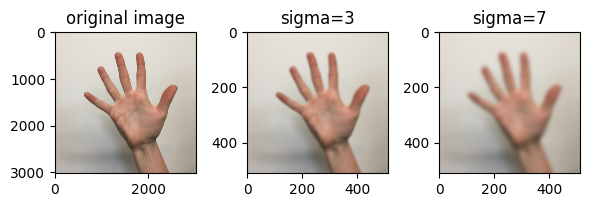

In [23]:
downsized_img = T.Resize(size=512)(orig_img)
blurred_imgs = [T.GaussianBlur(kernel_size=(51, 91), sigma=sigma)(downsized_img) for sigma in (3,7)]
plot_examples(blurred_imgs, ['sigma=3', 'sigma=7'])

**Gaussian Noise** <br>
The Gaussian Noise is a popular way to add noise to the whole dataset, forcing the model to learn the most important information contained in the data. It consists in injecting a Gaussian Noise matrix, which is a matrix of random values drawn from a Gaussian distribution. Later, we clip the samples between 0 and 1. The more the noise factor is higher, the more noisy the image is.

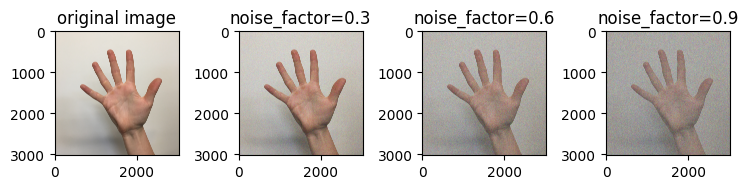

In [24]:
def add_noise(inputs,noise_factor=0.3):
    noisy = inputs+torch.randn_like(inputs) * noise_factor
    noisy = torch.clip(noisy,0.,1.)
    return noisy
    
noise_imgs = [add_noise(T.ToTensor()(orig_img),noise_factor) for noise_factor in (0.3,0.6,0.9)]
noise_imgs = [T.ToPILImage()(noise_img) for noise_img in noise_imgs]
plot_examples(noise_imgs, ["noise_factor=0.3","noise_factor=0.6","noise_factor=0.9"])

Usefull library: https://github.com/albumentations-team/albumentations

### Batch Normalization

In [25]:
# With Learnable Parameters
m = nn.BatchNorm1d(5) # num_features
input = torch.randn(4, 5)
# Without Learnable Parameters
m = nn.BatchNorm1d(5, affine=False) # learnable parameters γ and β

output = m(input)

print('Input:\n', input, '\n\n', f'mean {input.mean()}, std {input.std()}', '\n')
print('Output:\n', input, '\n\n', f'mean {output.mean()}, std {output.std()}', '\n')

Input:
 tensor([[ 1.3142, -0.9728, -0.2880, -0.1489,  0.5898],
        [-0.8402,  0.1501, -0.7923,  0.4119, -0.0793],
        [-1.2004, -1.0095,  0.8554,  0.3305,  0.6692],
        [ 0.3361, -1.4544, -0.4421, -0.3659, -0.3190]]) 

 mean -0.16277852654457092, std 0.7447030544281006 

Output:
 tensor([[ 1.3142, -0.9728, -0.2880, -0.1489,  0.5898],
        [-0.8402,  0.1501, -0.7923,  0.4119, -0.0793],
        [-1.2004, -1.0095,  0.8554,  0.3305,  0.6692],
        [ 0.3361, -1.4544, -0.4421, -0.3659, -0.3190]]) 

 mean 2.9802322831784522e-09, std 1.0259562730789185 



## Baseline

In [26]:
class SIGNSDataset(Dataset):
    def __init__(self, data_dir, transform):      
        #store filenames
        self.filenames = os.listdir(data_dir)
        self.filenames = [os.path.join(data_dir, f) for f in self.filenames if f.endswith('.jpg')]
        #the first character of the filename contains the label
        self.labels = [int(filename.split('/')[-1][0]) for filename in self.filenames]
        self.transform = transform

    def __len__(self):
        #return size of dataset
        return len(self.filenames)

    def __getitem__(self, idx):
        #open image, apply transforms and return with label
        image = Image.open(self.filenames[idx])  # PIL image
        image = self.transform(image)
        return image, self.labels[idx]

In [27]:
train_transformer = T.Compose([
    T.Resize(64),              # resize the image to 64x64 
    T.RandomHorizontalFlip(),  # randomly flip image horizontally
    T.ToTensor()])             # transform it into a PyTorch Tensor

test_transformer = T.Compose([
    T.Resize(64),
    T.ToTensor()])

In [28]:
train_dataset = SIGNSDataset(f'{data_path}train_signs/', train_transformer)
test_dataset = SIGNSDataset(f'{data_path}test_signs/', test_transformer)

In [29]:
class BaselineModel(nn.Module):

    def __init__(self, ): 
        super().__init__()
        self.num_channels = 32
        
        # each of the convolution layers below have the arguments (input_channels, output_channels, filter_size,
        # stride, padding). We also include batch normalisation layers that help stabilise training.

        self.conv1 = nn.Conv2d(3, self.num_channels, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(self.num_channels, self.num_channels*2, 3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(self.num_channels*2, self.num_channels*4, 3, stride=1, padding=1)

        # 2 fully connected layers to transform the output of the convolution layers to the final output
        self.fc1 = nn.Linear(8*8*self.num_channels*4, self.num_channels*4)
        self.fc2 = nn.Linear(self.num_channels*4, 6)       

    def forward(self, s):
        #                                                  -> batch_size x 3 x 64 x 64
        # we apply the convolution layers, followed by batch normalisation, maxpool and relu x 3
        s = self.conv1(s)                                   # batch_size x num_channels x 64 x 64
        s = F.relu(F.max_pool2d(s, 2))                      # batch_size x num_channels x 32 x 32
        s = self.conv2(s)                                   # batch_size x num_channels*2 x 32 x 32
        s = F.relu(F.max_pool2d(s, 2))                      # batch_size x num_channels*2 x 16 x 16
        s = self.conv3(s)                                   # batch_size x num_channels*4 x 16 x 16
        s = F.relu(F.max_pool2d(s, 2))                      # batch_size x num_channels*4 x 8 x 8

        # flatten the output for each image
        s = s.view(-1, 8*8*self.num_channels*4)             # batch_size x 8*8*num_channels*4

        # apply 2 fully connected layers with dropout
        s = F.relu(self.fc1(s))                             # batch_size x self.num_channels*4
        s = self.fc2(s)                                     # batch_size x 6

        # apply log softmax on each image's output (this is recommended over applying softmax
        # since it is numerically more stable)
        return F.log_softmax(s, dim=1)


In [30]:
cuda = torch.cuda.is_available()  

# Set the random seed for reproducible experiments
torch.manual_seed(42)
if cuda:
    cuda.manual_seed(42)

# Specify a computing device
device = 'cuda' if cuda else None

In [31]:
train_dataloader = DataLoader(train_dataset,
                              batch_size=32, 
                              shuffle=True,
                              num_workers=4)

test_dataloader = DataLoader(test_dataset,
                             batch_size=32, 
                             shuffle=False,
                             num_workers=1)

In [32]:
# Define the model and optimizer
model = BaselineModel().to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [33]:
model

BaselineModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=8192, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=6, bias=True)
)

In [34]:
# Define loss function
criterion = nn.CrossEntropyLoss().to(device)

# Train the model

train_losses = []
train_accs = []

test_losses = []
test_accs = []

num_epochs = 15

for epoch in tqdm(range(num_epochs)):
    
    # Train step
    
    model.train()
    
    train_epoch_loss = []
    train_epoch_acc = []
    
    for i, (train_batch, labels_batch) in tqdm(enumerate(train_dataloader)):
        if cuda:
            train_batch, labels_batch = train_batch.cuda(non_blocking=True), labels_batch.cuda(non_blocking=True)

        # compute model output and loss
        output_batch = model(train_batch)

        loss = criterion(output_batch, labels_batch)

        # clear previous gradients, compute gradients of all variables wrt loss
        optimizer.zero_grad()
        loss.backward()

        # performs updates using calculated gradients
        optimizer.step()
        
        batch_loss = loss.cpu().detach().numpy()
        batch_acc = balanced_accuracy_score(np.argmax(output_batch.cpu().detach().numpy(), axis=1),
                                            labels_batch.cpu().detach().numpy())
        
        train_epoch_loss.append(batch_loss)
        train_epoch_acc.append(batch_acc)
        
    
    print(f'Train epoch [{epoch+1}/{num_epochs}], Loss: {np.mean(train_epoch_loss):.4f}, Acc: {np.mean(train_epoch_acc)}')
    train_accs.append(np.mean(train_epoch_acc))
    train_losses.append(np.mean(train_epoch_loss))
    
    # Eval step
    
    model.eval()
    
    test_epoch_loss = []
    test_epoch_acc = []
    
    with torch.no_grad():
        
        for i, (test_batch, labels_batch) in enumerate(test_dataloader):
            if cuda:
                test_batch, labels_batch = test_batch.cuda(non_blocking=True), labels_batch.cuda(non_blocking=True)

            # compute model output and loss
            output_batch = model(test_batch)

            loss = criterion(output_batch, labels_batch)

            batch_loss = loss.cpu().detach().numpy()
            batch_acc = balanced_accuracy_score(np.argmax(output_batch.cpu().detach().numpy(), axis=1),
                                                labels_batch.cpu().detach().numpy())

            test_epoch_loss.append(batch_loss)
            test_epoch_acc.append(batch_acc)
    print(f'Test epoch [{epoch+1}/{num_epochs}], Loss: {np.mean(test_epoch_loss):.4f}, Acc: {np.mean(test_epoch_acc)}')        
    test_accs.append(np.mean(test_epoch_acc))
    test_losses.append(np.mean(test_epoch_loss))

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Train epoch [1/15], Loss: 1.7932, Acc: 0.1539975501985306
Test epoch [1/15], Loss: 1.7801, Acc: 0.4011000233426704


0it [00:00, ?it/s]

Train epoch [2/15], Loss: 1.6139, Acc: 0.4161406696900775
Test epoch [2/15], Loss: 1.3400, Acc: 0.5610780423280423


0it [00:00, ?it/s]

Train epoch [3/15], Loss: 1.2390, Acc: 0.5841363967315525
Test epoch [3/15], Loss: 1.1137, Acc: 0.6916501322751323


0it [00:00, ?it/s]

Train epoch [4/15], Loss: 0.9469, Acc: 0.6681874688492334
Test epoch [4/15], Loss: 0.7885, Acc: 0.7687499999999999


0it [00:00, ?it/s]

Train epoch [5/15], Loss: 0.7379, Acc: 0.7698803864980335
Test epoch [5/15], Loss: 0.6359, Acc: 0.8227182539682539


0it [00:00, ?it/s]

Train epoch [6/15], Loss: 0.5489, Acc: 0.8223349743937979
Test epoch [6/15], Loss: 0.5322, Acc: 0.8071428571428572


0it [00:00, ?it/s]

Train epoch [7/15], Loss: 0.4147, Acc: 0.87406279178338
Test epoch [7/15], Loss: 0.4477, Acc: 0.8608630952380952


0it [00:00, ?it/s]

Train epoch [8/15], Loss: 0.3781, Acc: 0.8791334564128683
Test epoch [8/15], Loss: 0.4321, Acc: 0.9041335978835979


0it [00:00, ?it/s]

Train epoch [9/15], Loss: 0.2994, Acc: 0.9058855360325948
Test epoch [9/15], Loss: 0.3355, Acc: 0.9027281746031746


0it [00:00, ?it/s]

Train epoch [10/15], Loss: 0.2652, Acc: 0.9166031463090285
Test epoch [10/15], Loss: 0.3554, Acc: 0.8670304232804233


0it [00:00, ?it/s]

Train epoch [11/15], Loss: 0.2041, Acc: 0.9364007724301842
Test epoch [11/15], Loss: 0.3358, Acc: 0.8926256613756614


0it [00:00, ?it/s]

Train epoch [12/15], Loss: 0.2107, Acc: 0.9374002631355572
Test epoch [12/15], Loss: 0.3333, Acc: 0.899074074074074


0it [00:00, ?it/s]

Train epoch [13/15], Loss: 0.1754, Acc: 0.9479648020824492
Test epoch [13/15], Loss: 0.2779, Acc: 0.914699074074074


0it [00:00, ?it/s]

Train epoch [14/15], Loss: 0.1710, Acc: 0.9449673556291203
Test epoch [14/15], Loss: 0.2231, Acc: 0.9271494708994709


0it [00:00, ?it/s]

Train epoch [15/15], Loss: 0.1180, Acc: 0.9653928451722569
Test epoch [15/15], Loss: 0.2318, Acc: 0.9316137566137566


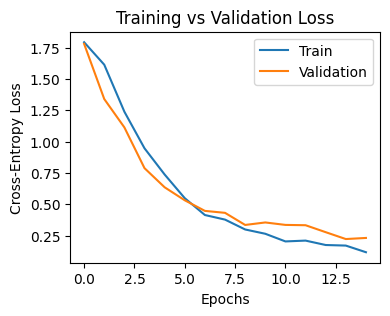

In [35]:
plt.figure(figsize=(4, 3))
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Validation')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.title('Training vs Validation Loss')
plt.show()

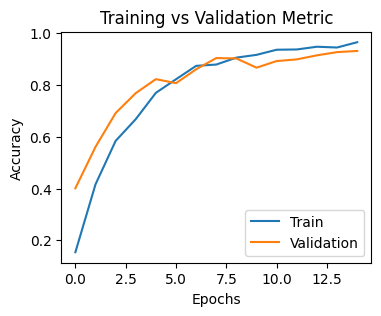

In [36]:
plt.figure(figsize=(4, 3))
plt.plot(train_accs, label='Train')
plt.plot(test_accs, label='Validation')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Metric')
plt.show()